<a href="https://colab.research.google.com/github/riyagpt0251/EcoSense/blob/main/Ecosense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pandas numpy matplotlib scikit-learn tensorflow

load and preprocess the dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
df = pd.read_csv(url, sep=";", parse_dates={"DateTime": ["Date", "Time"]}, infer_datetime_format=True, low_memory=False)

# Handle missing values
df.replace("?", np.nan, inplace=True)
df = df.ffill()  # Forward fill missing values

# Convert columns to numeric
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric)

# Select relevant columns
df = df[["DateTime", "Global_active_power"]]
df.set_index("DateTime", inplace=True)

# Resample data to hourly frequency
df = df.resample("H").mean()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Prepare training data
def create_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 24  # Use 24 hours of data to predict the next hour
X, y = create_dataset(scaled_data, look_back)

# Reshape data for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

<ipython-input-3-626c8b498566>:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(url, sep=";", parse_dates={"DateTime": ["Date", "Time"]}, infer_datetime_format=True, low_memory=False)
<ipython-input-3-626c8b498566>:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(url, sep=";", parse_dates={"DateTime": ["Date", "Time"]}, infer_datetime_format=True, low_memory=False)
<ipython-input-3-626c8b498566>:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(url, sep=";", parse_dates={"Date

build and train the lstm model

In [4]:
# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0139 - val_loss: 0.0069
Epoch 2/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 0.0095 - val_loss: 0.0066
Epoch 3/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 4/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.0089 - val_loss: 0.0063
Epoch 5/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 6/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 7/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 8/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 9/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 10/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0088 - val_loss: 0.0063


make prediction

217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


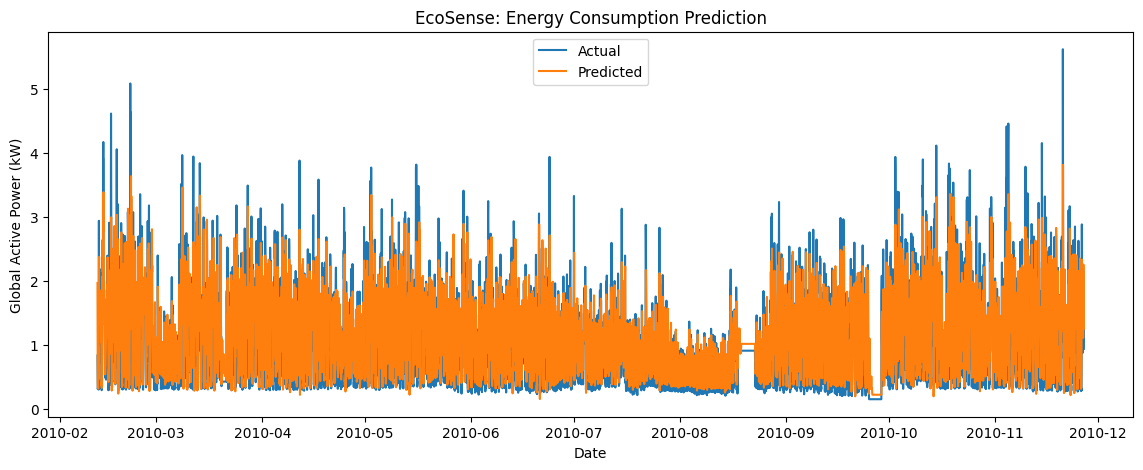

In [5]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual")
plt.plot(df.index[-len(y_test):], predictions, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("EcoSense: Energy Consumption Prediction")
plt.legend()
plt.show()